## Imports üì¶

In [1]:
import pandas as pd
import numpy as np
import emoji
import warnings
import nltk
from nltk.corpus import stopwords    
import string
import statistics
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
warnings.filterwarnings('ignore')

## Load Data üíø

In [3]:
df = pd.read_csv("Data/cleaned_by_language.csv")

In [4]:
en_df = df[df['language'] == 'en']
es_df = df[df['language'] == 'es']

In [5]:
en_comment = en_df['text only'].to_list()
es_comment = es_df['text only'].to_list()
en_comment_with_emoji = en_df['text'].to_list()
es_comment_with_emoji = es_df['text'].to_list()

In [6]:
nltk.download('punkt')
nltk.download('stopwords')
en_stop_words = set(stopwords.words('english'))
es_stop_words = set(stopwords.words('spanish'))

def filter_comments(comment_list, stop_words):
    filtered_comments = []

    for comment in comment_list:
        # remove word starts with @
        comment = " ".join(filter(lambda x:x[0]!='@', comment.split()))
    
        # remove punctuations
        comment = comment.translate(str.maketrans('', '', string.punctuation))

        # remove stopwords
        words = nltk.word_tokenize(comment)
        filtered_comment = [word for word in words if word.lower() not in stop_words]
        filtered_comment = ' '.join(filtered_comment)
        filtered_comment = comment
        filtered_comments.append(filtered_comment)
    return filtered_comments

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yuhsinhuang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yuhsinhuang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
en_filtered_comments = filter_comments(en_comment, en_stop_words)
es_filtered_comments = filter_comments(es_comment, es_stop_words)
en_with_emoji_filtered_comments = filter_comments(en_comment_with_emoji, en_stop_words)
es_with_emoji_filtered_comments = filter_comments(es_comment_with_emoji, es_stop_words)

## Text Embeddings using LASER - this pretrained model supports cross-lingual tasks and embeds in setence-level

In [8]:
pip install laserembeddings

Note: you may need to restart the kernel to use updated packages.


In [9]:
# run this in terminal first: python -m laserembeddings download-models
from laserembeddings import Laser

laser = Laser()
en_text_array = laser.embed_sentences(en_filtered_comments, lang='en')
es_text_array = laser.embed_sentences(es_filtered_comments, lang='es')
en_array = laser.embed_sentences(en_with_emoji_filtered_comments, lang='en')
es_array = laser.embed_sentences(es_with_emoji_filtered_comments, lang='es')

In [10]:
en_text_array.shape

(280, 1024)

## Emoji Embeddings using Emoji2Vec

In [11]:
from gensim.models import KeyedVectors

# Load pretrained emoji embeddings
emoji_model = KeyedVectors.load_word2vec_format('emoji2vec.bin', binary=True)

def emoji_embedding(df):
    emoji_list_list = df['emoji list'].to_list()

    # Initialize a list to store emoji embeddings
    emoji_embedding = []

    for emoji_list in emoji_list_list:
        emoji_list_embedding = []
        for emoji in emoji_list:
            try:
                emoji_list_embedding.append(emoji_model[emoji])
                
            except KeyError:
                pass

            # if len(emoji_list_embedding) != 0:
            # emoji_list_embedding = np.concatenate(emoji_list_embedding, axis=0)
        emoji_embedding.append(emoji_list_embedding)
    
    # average
    res = []
    for embeddings in emoji_embedding:
        average_embedding = np.mean(embeddings, axis=0)
        # padded arrays with zero emojis with a length 300 array filled with zeros
        if average_embedding is None or np.isnan(average_embedding).all():
            res.append(np.zeros(300))
        else:
            res.append(average_embedding)
    
    return np.array(res)

# en_max_size = max(len(arr) for arr in en_emoji_embedding)
# en_padded_arrays = [np.pad(arr, (0, en_max_size - len(arr)), 'constant') for arr in en_emoji_embedding]
# en_emoji_array = np.vstack(en_padded_arrays)

In [12]:
en_emoji_array = emoji_embedding(en_df)
es_emoji_array = emoji_embedding(es_df)

In [13]:
es_emoji_array.shape

(280, 300)

## Concatenate the text embeddings and emoji embeddings 

In [14]:
# Concatenate along columns (horizontally)
en_embeddings = np.concatenate((en_text_array, en_emoji_array), axis=1)
es_embeddings = np.concatenate((es_text_array, es_emoji_array), axis=1)

In [15]:
en_embeddings.shape

(280, 1324)

## Variable names üìá
- en_text_array: LASER embeddings on text only (shape:280x1024)
- en_emoji_array: emoji2vec embeddings on emoji only (shape: 280x300)
- en_embeddings: concatenate en_text_array and en_emoji_array (shape: 280, 1324)
- en_array: LASER embeddings on text+emoji (shape: 280x1024)
- (replace en by es to get result from Spanish dataset)

## Hierarchical Clustering ü™ú

In [50]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_samples

def apply_hierarchical_clustering(lang_embeddings, lang_df):
    # method = 'single', 'complete', 'average' don't cluster well
    linkage_matrix = linkage(lang_embeddings, method='ward')
    
    # Plotting dendrogram
    plt.figure(figsize=(24, 16))
    dendrogram(linkage_matrix, labels=lang_df['text'].tolist(), orientation='top', distance_sort='descending', show_leaf_counts=True)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Comments')
    plt.ylabel('Distance')
    plt.show()

    # can try different thresholds and criterion
    cluster_labels = fcluster(linkage_matrix, t=3, criterion='distance')

    silhouette_scores = silhouette_samples(lang_embeddings, cluster_labels)

    df_clusters = pd.DataFrame({
        "text": lang_df['text'],
        "cluster": cluster_labels,
        "silhouette_score": silhouette_scores
    })

    cluster_mean_silhouette = df_clusters.groupby('cluster')['silhouette_score'].mean().reset_index()
    df_clusters = df_clusters.merge(cluster_mean_silhouette, on='cluster', suffixes=('', '_mean'))
    df_clusters = df_clusters.sort_values(by='silhouette_score_mean', ascending=False).drop('silhouette_score_mean', axis=1)

    return df_clusters, cluster_mean_silhouette

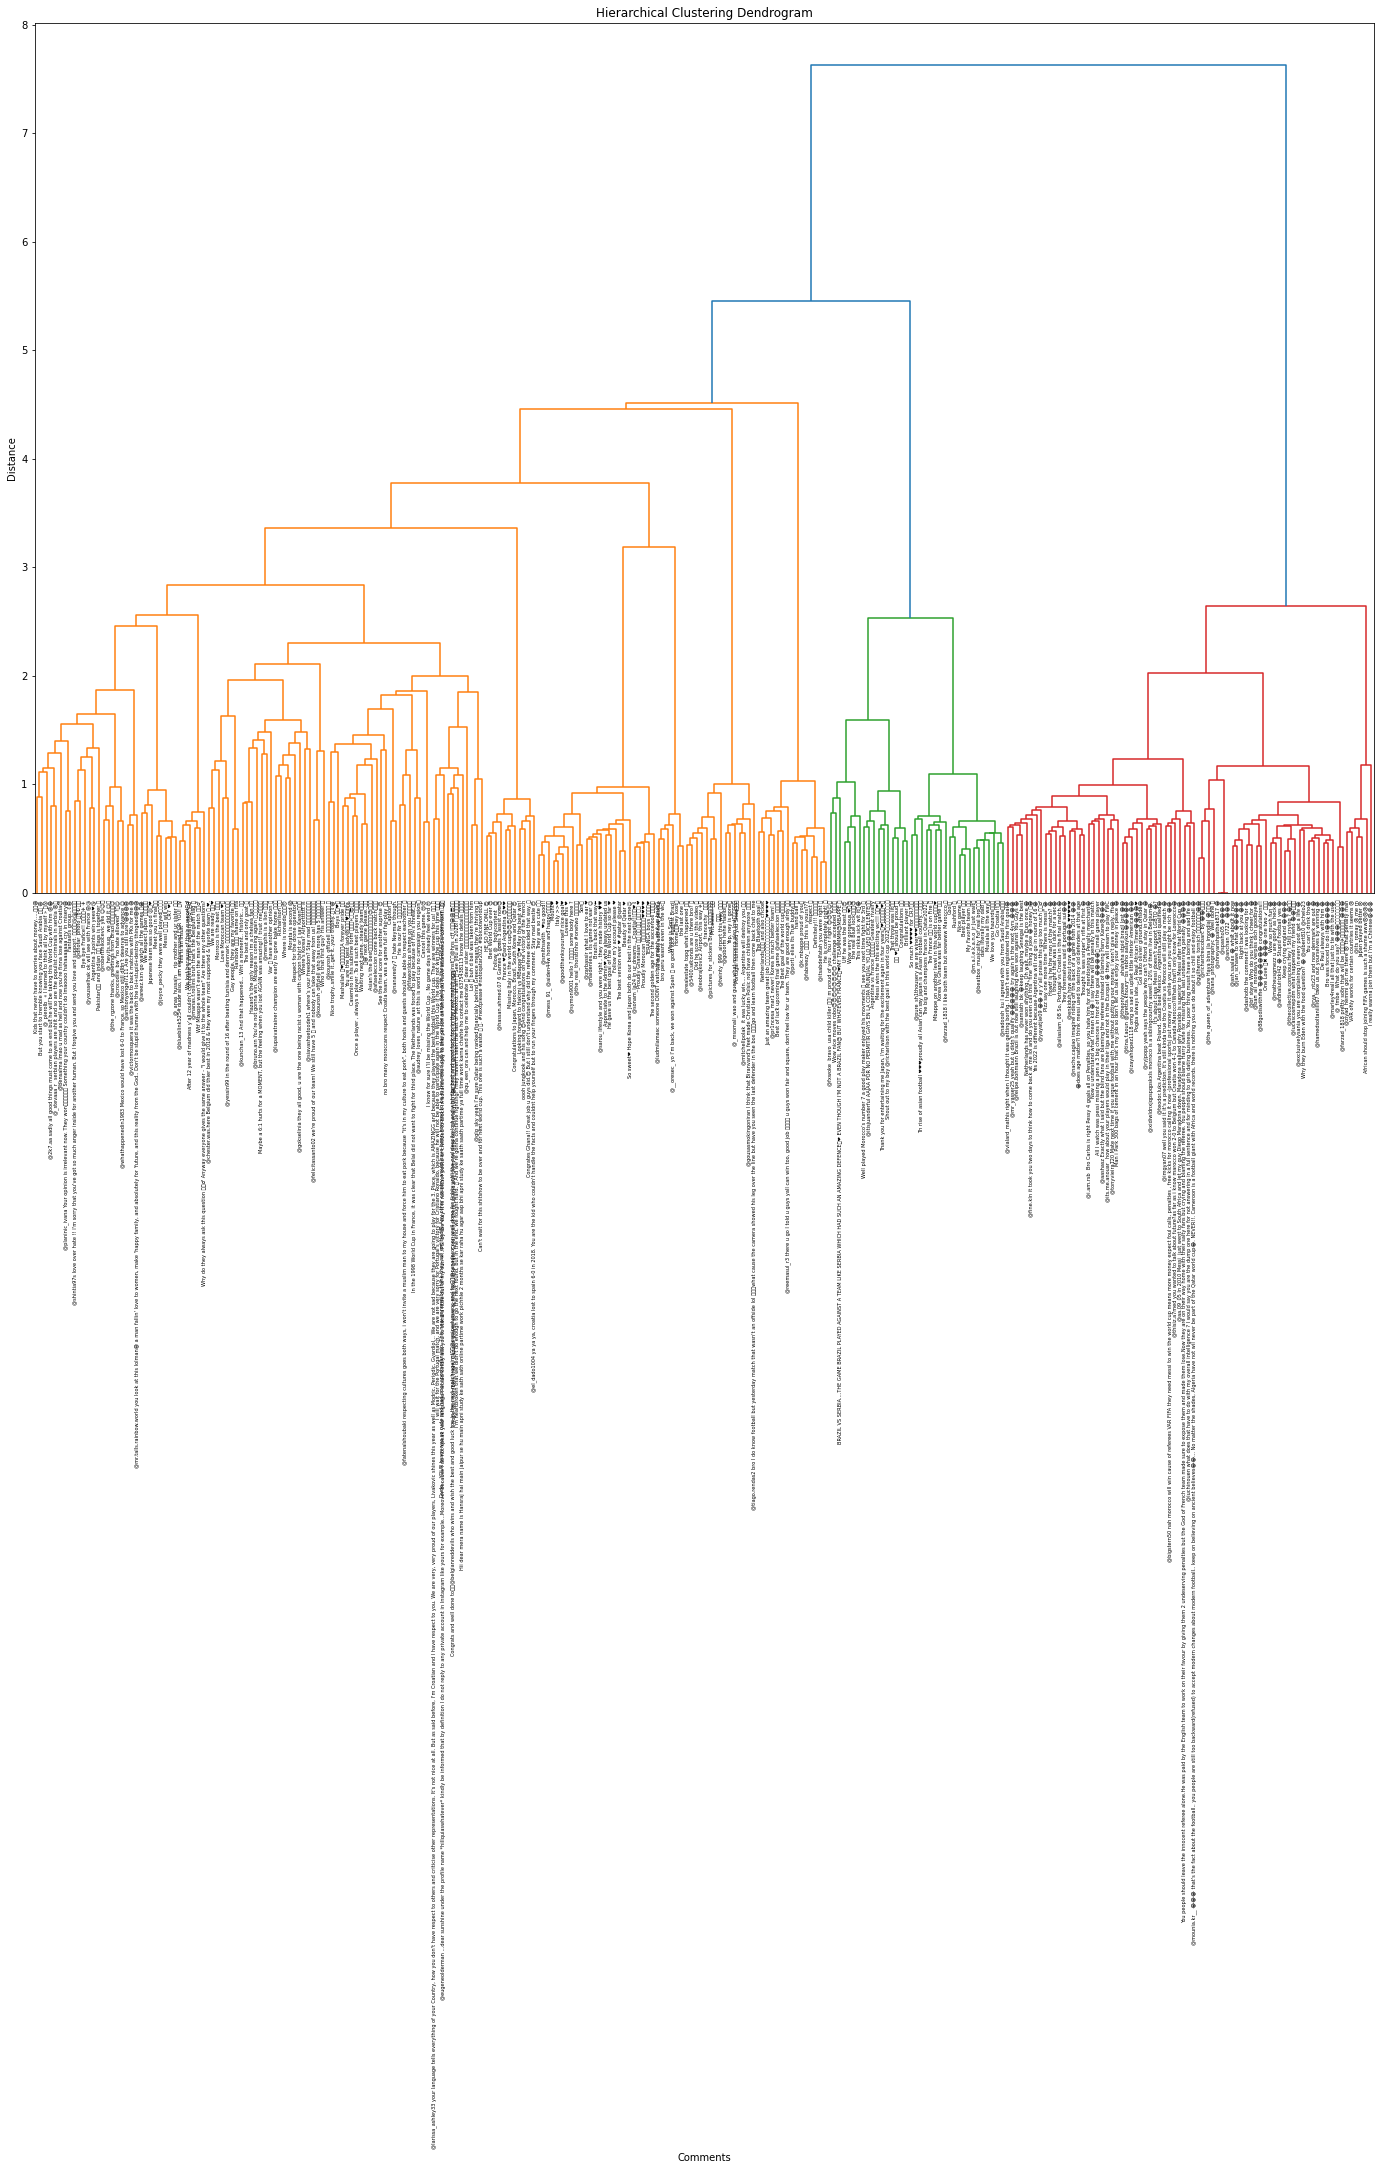

In [51]:
# Perform hierarchical clustering
en_linkage_matrix, en_mean_silhouette = apply_hierarchical_clustering(en_embeddings, en_df)

In [19]:
en_linkage_matrix

text  cluster  \
279                                         They kostüíÄ        5   
278  @ludmilamasc someone DIDNT watch the match. sh...        5   
277                     bro peru wasnt even in the wcüíÄ        5   
276  @__oresec_ yo I‚Äôm back, we won against Spain üíÄ...        5   
275  All out lets add new people\n\nWhere is Son?\n...        5   
..                                                 ...      ...   
162  @lupaivatrainer champion are early to gone bak...        8   
163                                          Caption üíØ        8   
164              Mashallah üôå‚ù§Ô∏èüá≤üá¶üá≤üá¶üá≤üá¶A forever pride üëèüí™        8   
165                    Respect for the drone operatorüõê        8   
140                Lol üôÑ buh d ball was taken from him        8   

     silhouette_score  
279          0.496161  
278          0.512258  
277          0.509701  
276          0.468551  
275          0.501797  
..                ...  
162         -0.237944  
163         -0.123070  
164         -0.157364  
165         -0.176191  
140         -0.102557  

[280 rows x 3 columns]

In [20]:
en_mean_silhouette

cluster  silhouette_score
0        1          0.346112
1        2          0.224781
2        3          0.476288
3        4          0.417821
4        5          0.498986
5        6          0.485666
6        7          0.422899
7        8         -0.124502

In [21]:
en_linkage_matrix[en_linkage_matrix['cluster'] == 5]['text'].tolist()

['They kostüíÄ',
 '@ludmilamasc someone DIDNT watch the match. shut up bruhüíÄ.',
 'bro peru wasnt even in the wcüíÄ',
 '@__oresec_ yo I‚Äôm back, we won against Spain üíÄ so good luck against Brazil',
 'All out lets add new people\n\nWhere is Son?\nHomeüíÄüíÄ',
 'the last one üíÄ']

In [22]:
en_linkage_matrix[en_linkage_matrix['cluster'] == 6]['text'].tolist()

['Italy >>‚ù§Ô∏è',
 'Proudly Ghanaian üá¨üá≠ üá¨üá≠ üá¨üá≠ üá¨üá≠ üá¨üá≠ ‚ù§Ô∏è',
 'Follow m‚Äôy account please ‚ù§Ô∏è',
 '@maidenles.s its game not war ‚ò∫Ô∏è',
 'Mount‚ù§Ô∏è',
 '@smithswith_ ‚ù§Ô∏èso good!!',
 'Beauty of Qatar ‚ù§Ô∏è',
 '@the_real_thorstinho #onetwo ü§≠ü§≠ü§≠ü§≠ü§≠',
 'The best version ever ‚ù§Ô∏è #qatar @qatar',
 '@goodthanksyourself nice goal‚ù§Ô∏è',
 '@zarbassir what I love to ear ‚ù§Ô∏è',
 'He gave us the best goal of the World Cup so far ‚ù§Ô∏è',
 'The second golden age for the socceroos üá¶üá∫üü°üü¢',
 'Loveee this ‚ù§Ô∏è',
 'Sonü•∫',
 'They are so cute \U0001f979\U0001f979',
 '@sarou_lifestyle and you were right , they made history ‚ô•Ô∏è‚ô•Ô∏è',
 'Appreciate to the Admin‚ù§Ô∏è who always updated us',
 'Proudly Moroccan üá≤üá¶üá≤üá¶üá≤üá¶üá≤üá¶‚ù§Ô∏è‚ù§Ô∏è‚ù§Ô∏è‚ù§Ô∏è',
 '@mess_91_ @aiden44w home and happyü•≥ü•≥ü§åüèª',
 '@symon9001 hello ? ü§üüèΩüá¶üá∑ some body here ?',
 'Brazils back that way‚¨ÖÔ∏è',
 'TERANGA boys üá∏ü

In [23]:
en_linkage_matrix[en_linkage_matrix['cluster'] == 3]['text'].tolist()

['@pr1ncesa_mar1 never! Korea is much better team! üëè',
 'Just an amazing team great job üëèüèªüëèüèªüëèüèªüëèüèªüëèüèªüëèüèªüëèüèªüëèüèª‚ù§Ô∏è‚ù§Ô∏è‚ù§Ô∏è‚ù§Ô∏è',
 '@k.mbappe proud of youüëè',
 'Definitely!!! üëèüëèüëèüëèüëè',
 'Best of luck upcoming final game @afaseleccion üëèüëèüëèüèÜ',
 '@porti_elias Its True buddyüëèüëè',
 '@reemasul_r3 there u go I told u guys yall can win too, good job üëèüèªüëèüèª u guys won fair and square, dont feel low for ur team. They are good enough alrdy üëèüèª',
 '@fabreezy_ üëèüëèüëè this is yours???',
 'The Best goal of the world cupüëèüëèüëè‚öΩÔ∏è',
 'He is completely right! üëè',
 'respect üëè',
 'Netherlandsüëèüëèüëè and also cricket',
 'hand ball üëè',
 'The Bluetooth goal üëè',
 '@itsabdelfatah you were right üëè']

In [24]:
en_linkage_matrix[en_linkage_matrix['cluster'] == 7]['text'].tolist()

['Best World Cup ever üòç',
 "Congrates Ghana!! Great job u guys did.üòç But I still don't understand why did the referee decided that way. ü•≤",
 'Missing Italy in the world cupüòçüòçüòçüáÆüáπüáÆüáπüáÆüáπ',
 'Congratulations to Japan, Morocco, Brazil, South Korea and Qatar üòç',
 'HE SO FINE OMLL üòç',
 'Follow @__footycontent_ üòç',
 'France ‚ù§Ô∏èüòçand Argentina üòç‚ù§Ô∏è‚ù§Ô∏è',
 "Looking forward to Hakimi vs MBappe'üòç‚ù§Ô∏è May the best win!",
 "@el_dado1004 ya ya ya, croatia lost to spain 6-0 in 2018. You are the kid who couldn't handle the facts and couldnt help yourself but to run your fingers through my comment. Stay mad bestie üòç",
 '@hassan.ahmed.07 6 Games 5 goals 3 assist nowüòç',
 'oooh jungkook and his song üòçAnd congratulations on the victory of the French']

In [25]:
en_linkage_matrix[en_linkage_matrix['cluster'] == 4]['text'].tolist()

['Yep, ney is goneü§£',
 'Did he score in this video ü§£',
 '@twinty_999  airport this way ü§£üëçüèª',
 '@_francechy_ ü§£ü§£ü§£',
 '@5400.seconds are u there bro? ü§£',
 "@gousasmokingoniran I think that Biranvand's feet made Christian Polsic not have children anymore ü§£ü§£ü§£",
 '@realestate_topg what happened ü§£ü§£',
 '@mitchellpolak  it was lucky win.... Argentine will destroy you ü§£ü§£',
 'Priceless!! üá®üá≤\nü§£ü§£ü§£',
 "@tiago.rendas2 bro I do know football but yesterday match that wasn't an offside lol ü§£ü§£ü§£what cause the camera showed his leg over the line but have you seen the last defender in the box ü§£ü§£ü§£go and learn football then come back chat to me",
 'Portugal humiliated you Shaqü§£ü§£ü§£\nÔøº',
 '@pictures_for_stickers Brazil üáßüá∑üõ´üè†ü§£ü§£ü§£ü§£',
 '@_msomali_wao and guess what morocco also lostü§£ü§£ü§£ü§£ü§£ü§£',
 '@goborm hehe Habibiü§£ü§£',
 '@leobrajkovic2 Airport, this way ‚úàÔ∏èü§£']

## Spanish

In [26]:
pip install googletrans==4.0.0-rc1

  Using cached httpx-0.13.3-py3-none-any.whl (55 kB)
  Using cached idna-2.10-py2.py3-none-any.whl (58 kB)
  Using cached httpcore-0.9.1-py3-none-any.whl (42 kB)
  Using cached h11-0.9.0-py2.py3-none-any.whl (53 kB)
  Attempting uninstall: h11
    Found existing installation: h11 0.14.0
    Uninstalling h11-0.14.0:
      Successfully uninstalled h11-0.14.0
  Attempting uninstall: idna
    Found existing installation: idna 3.4
    Uninstalling idna-3.4:
      Successfully uninstalled idna-3.4
  Attempting uninstall: httpcore
    Found existing installation: httpcore 1.0.2
    Uninstalling httpcore-1.0.2:
      Successfully uninstalled httpcore-1.0.2
  Attempting uninstall: httpx
    Found existing installation: httpx 0.25.1
    Uninstalling httpx-0.25.1:
      Successfully uninstalled httpx-0.25.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.

In [27]:
from googletrans import Translator

# Initialize the translator
translator = Translator()

# Function to translate a text
def translate_text(text, target_language='en'):
    try:
        translation = translator.translate(text, dest=target_language)
        return translation.text
    except Exception as e:
        return str(e)

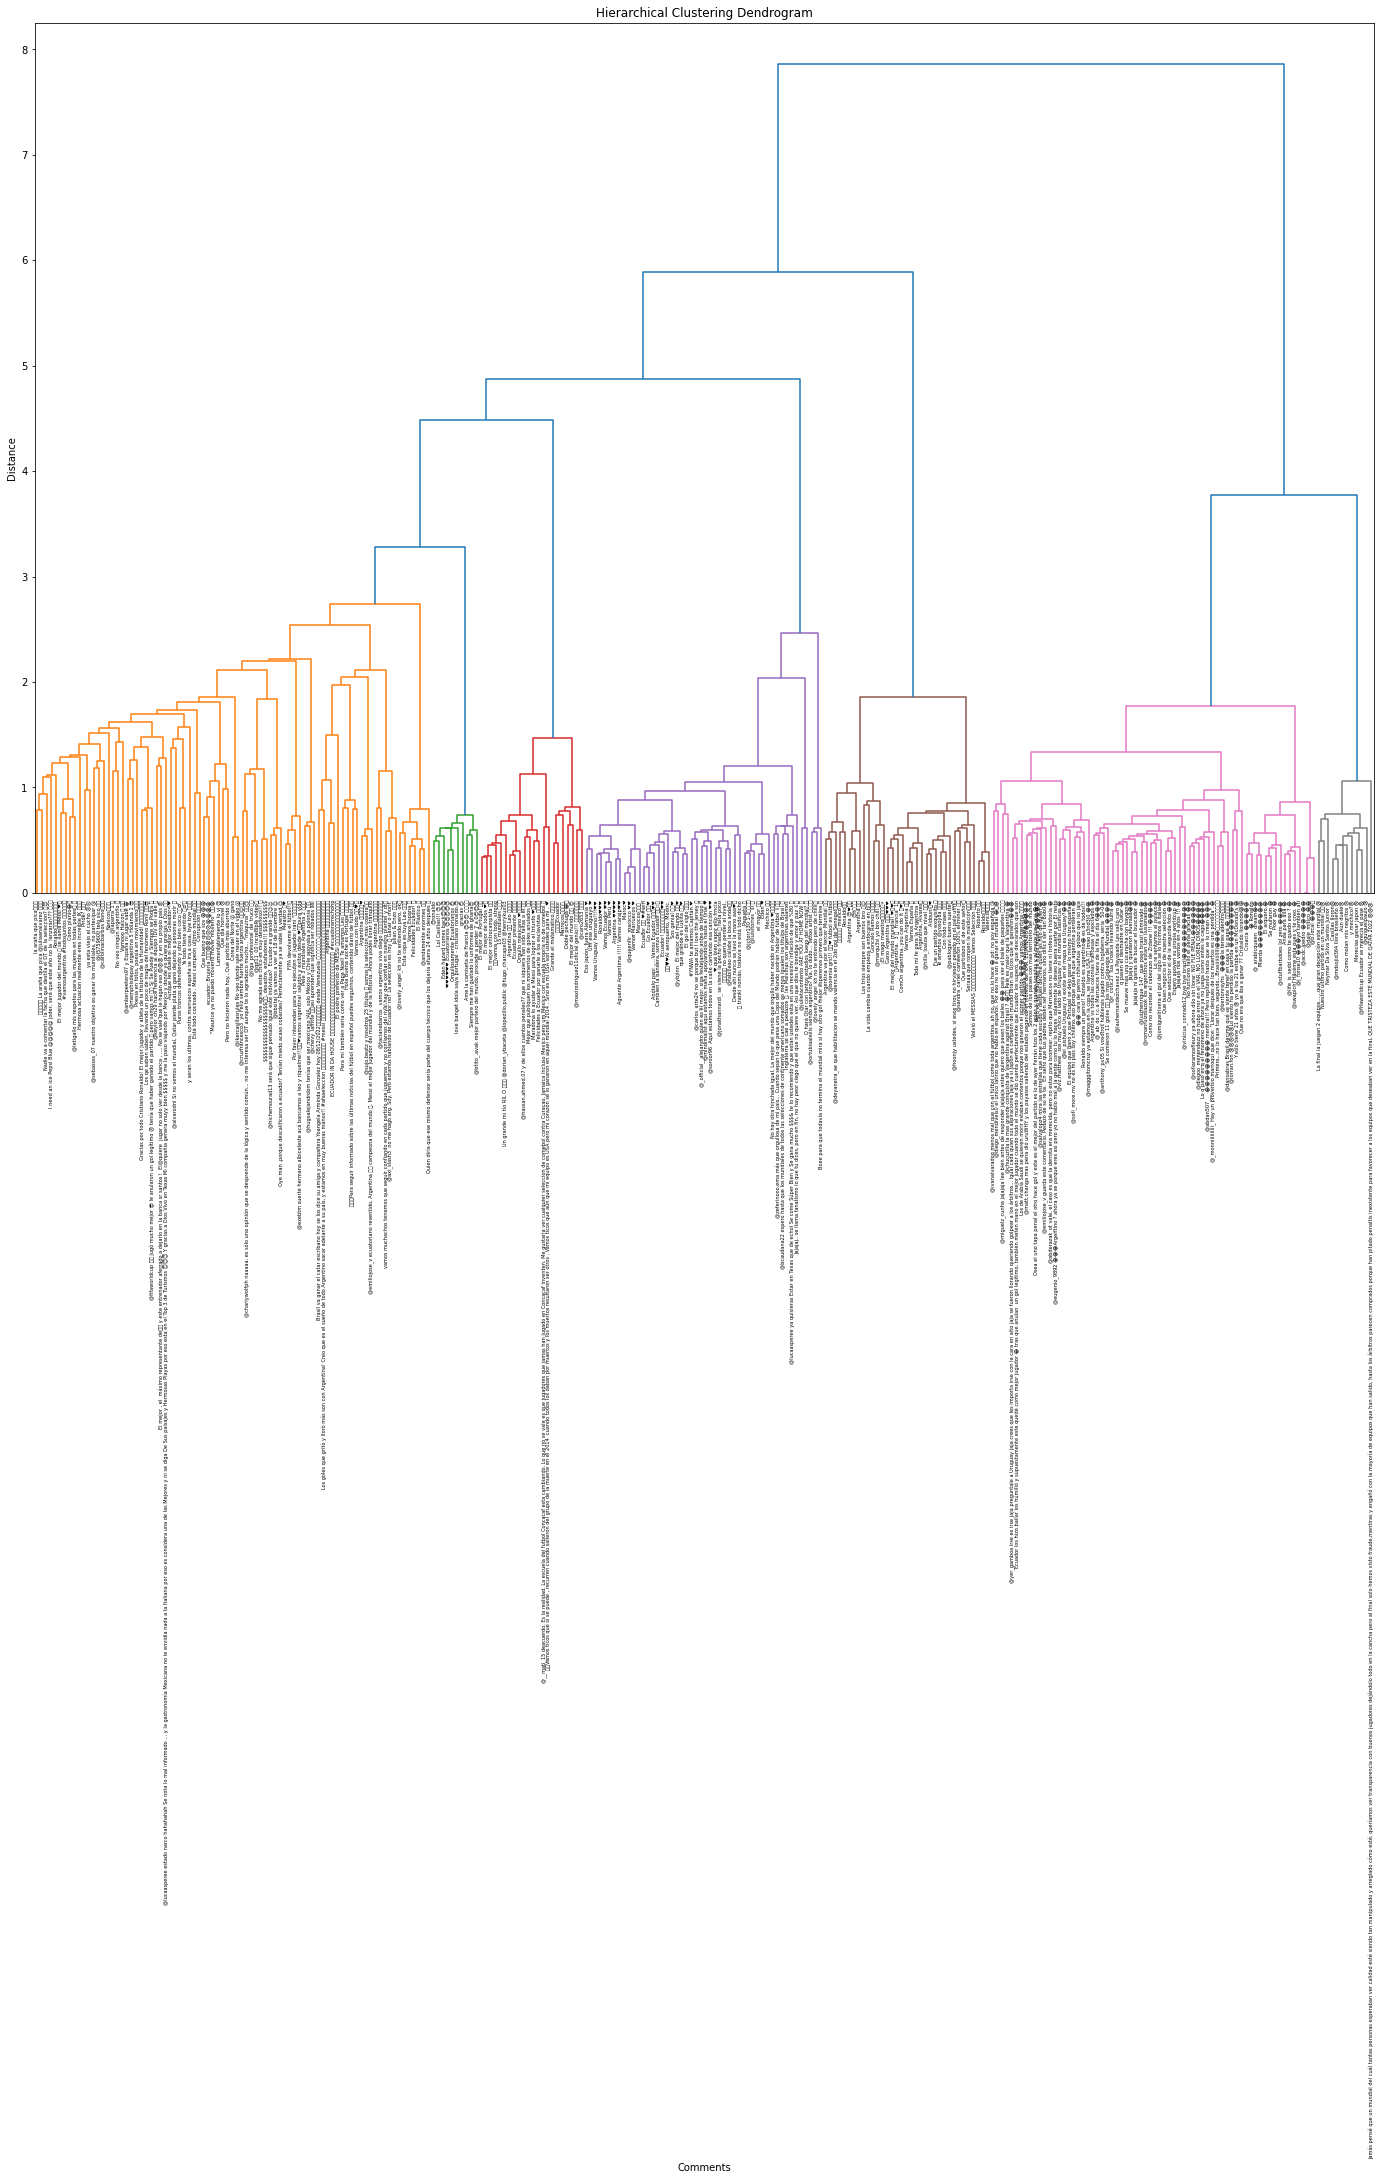

In [28]:
es_linkage_matrix, es_mean_silhouette = apply_hierarchical_clustering(es_embeddings, es_df)

In [29]:
es_linkage_matrix['translated_text'] = es_linkage_matrix['text'].apply(translate_text, target_language='en')
es_linkage_matrix

text  cluster  \
0                       Orgullosamente Ecuatorianos üòç        6   
2   @btito_.avak mejor portero del mundo, procede ...        6   
3                           Eden hazard comes backüòçüòçüòç        6   
4   love banget idola saya portugal - cristiano ro...        6   
5       Siempre me han gustado lo uniformes de ghanaüòç        6   
..                                                ...      ...   
45                                      El Pl√°stico üôå        7   
44  @ezebtm suerte hermano albiceleste ac√° bancamo...        7   
43  Oye man ,porque descalificaron a ecuador? Ten√≠...        7   
42                              la ara√±a que picaü§òüèªüï∑Ô∏è        7   
22                                 Vamooo Halc√≥n ü¶Ö üá∫üáæ        7   

    silhouette_score                                    translated_text  
0           0.502996                              Proudly Ecuadorians üòç  
2           0.443004  @Btito_.Avak Best goalkeeper in the world, pro...  
3           0.480451                          Eden hazard comes backüòçüòçüòç  
4           0.451412  I really love my idol Portugal - Cristiano Ron...  
5           0.472199              I have always liked Ghana's uniformsüòç  
..               ...                                                ...  
45         -0.021197                                      The plastic üôå  
44         -0.047228  @Ezebtm Lucky Brother Albiceleste here we bank...  
43         -0.100248  Hey Man, why did they disqualify Ecuador?They ...  
42         -0.154299                           The spider that Picaü§òüèªüï∑Ô∏è  
22         -0.158111                                 VAMOOO HALCON ü¶Ö üá∫üáæ  

[280 rows x 4 columns]

In [30]:
es_mean_silhouette

cluster  silhouette_score
0        1          0.428671
1        2          0.379912
2        3          0.388194
3        4          0.413665
4        5          0.394112
5        6          0.468130
6        7         -0.103273

In [31]:
es_linkage_matrix[es_linkage_matrix['cluster'] == 6]['translated_text'].tolist()

['Proudly Ecuadorians üòç',
 '@Btito_.Avak Best goalkeeper in the world, proceeds to lose 7 to 0üòçüòçüòç',
 'Eden hazard comes backüòçüòçüòç',
 'I really love my idol Portugal - Cristiano Ronaldo.üòç',
 "I have always liked Ghana's uniformsüòç",
 'Love the France shirt üòçüòçüòç üá∫üáæüá®üáµ',
 'Lol Casillas!!! üòçüòç',
 'gracias üòç',
 'üòçronaldo',
 '‚ù§Ô∏è‚ù§Ô∏è‚ù§Ô∏è located Ecuadorians üòçüòçüòçüòçüòç']

In [32]:
es_linkage_matrix[es_linkage_matrix['cluster'] == 1]['translated_text'].tolist()

['@guiguelpaulo üò¢',
 'How are my blacks shit üò¢',
 '@fifaworldcup Ecuador deserved the pass üò¢',
 'It still hurts',
 'and mechico? üò¢',
 'I never thought that a World Cup from which so many people expected to see quality is being so manipulated and fixed how it is, we wantedOut, even the referees seem bought because they have been a non -existent penalty to favor the teams they wanted to see in the final, how sad is the world of Qatar 2022 üò¢üò¢üò¢.',
 'You deserved to win Japon üò¢',
 'Neymar da Silva Santos Junior üò¢',
 '@mdsojid364 cries Brazilian üò¢',
 'Casillas Lloronüò¢',
 'Our last game in a World Cup üá®üá¥üò¢',
 'The final is played by 2 teams ...... What great disappointment this World Cup üò¢']

In [33]:
es_linkage_matrix[es_linkage_matrix['cluster'] == 4]['translated_text'].tolist()

['@_Ompoficial__Alejandro who is the best, continue to celebrate ahead of time ü§´',
 'the eldest ü§©ü§©',
 'Ecuador üá™üá® ‚ù§Ô∏è#win',
 '@Luisitorres_ Yes ü•µ',
 'That Japan, outside Germany ‚ù§Ô∏è',
 '@fabilleao Shock your mouth go',
 '@lucaasperee you would already want to be in Texas that Echol eats super good and you earn a lot $$$ & I recommend it and that you are in a recession/ inflation that %80 ü•µ',
 'Boee so that the World Cup is still not over if there is another better goal we hope first than end ü§ô',
 'There is no other fans the same.The best in the world that proud to have been born in Argentina ‚ù§Ô∏èüá¶üá∑üá¶üá∑',
 'From there the hand was washed AAA‚ù§Ô∏è\u200dü©π',
 "Argentina feed !!!!!Let's fuck bla ining",
 'Morocco‚ù§Ô∏è',
 'England falls to pieces ü•±, the Malvinas are Argentinas Salames',
 'Ronaldo‚ù§Ô∏è‚ù§Ô∏è‚ù§Ô∏è',
 '@bcaudana22 I wait until the World Cups of all the American continent selections somados less equal to the titles of Brazil \U

In [34]:
es_linkage_matrix[es_linkage_matrix['cluster'] == 5]['translated_text'].tolist()

['@caro2653 üëèüëèüëè',
 'Moroccsüëèüëèüëêüëê',
 'Argentina üá¶üá∑ Leo üëèüëèüëèüëè',
 '@hassan.ahmed.07 And how many penalties?that they have not even been fouls to El.üëèüëè',
 "@__ mati_15 agreement.It's reality.The Concacaf Soccer School is changing.What is not worth is that players who have never played in Concacaf invent.I would like to see any comebol selection against Curacao, Jamaica even Mexico but um mexico with School propria no de comebol üëè",
 '@Maxirodriguez11Oficial genius !!!üëèüëèüëèüëèüíôü§çüíô',
 'Double breast üòÇüëè',
 'The best midfielder üëèüèª',
 'A great my uncle Ril or üëèüëèüëè @dorian_ybaceta @lopezillo.public @hugo_charcape03 @hanrykux03',
 'Great the mathematician',
 'The best in Portugal üëèüëè',
 'Better publish the moments of canceled goals üëèüëè',
 'Mexican pride ‚ù§Ô∏èüëèüèªüá≤üáΩ',
 'Maradona help Messi to achieve triumph ‚ù§Ô∏èüëèüëèüëè',
 'Ecuador present üá™üá®üëèüëè',
 "We are thicerly that if one c

In [35]:
es_linkage_matrix[es_linkage_matrix['cluster'] == 3]['translated_text'].tolist()

['All my faith for Argentina üî•',
 '@Borenia Grs !!!üî•üôå‚ù§Ô∏è Soccer is football',
 '@marqu3si yo bro chill üëèüî•',
 'Argentina üî•üíö',
 "What's up the one of this lordüî•",
 '@hilla_loaiza what level üî•üî•üî•',
 'Aidoun üî•‚ù§Ô∏è',
 'Ronaldoüî•üî•üî•üî•',
 "Messias returned üá¶üá∑üá¶üá∑üá¶üá∑üá¶üá∑üá¶üá∑üá¶üá∑ Let's go selection üî•üî•üî•",
 '@deyaneira_ae to enable Valencia in the 2nd goal of Senegalüôåüî•üî•',
 '@pablogavi good lucküî•',
 'Valenciaüî•üî•üî•',
 'üòç√±üî•üî•üî•',
 'It will be to break the curseüî•üî•üî•',
 '@hoonjy you, if those shots did not get stuck in the Uffff sticküî•',
 '@sandra_cariel camereron 100% üî•üî•',
 'Life changes when it begins to focus on youüé∂üî•',
 "Let's go Spain üî•",
 'We love you @yosoy8a üá≤üáΩüî•',
 'The master magicianüî•üî•ü§çüëèüèª‚ö°',
 'Ronaldoüôåüî•',
 'With every teacher üî•üá®üá∑',
 'The best in the world!‚ù§Ô∏è\u200düî•‚ù§Ô∏è\u200düî•',
 'The trios are always 